In [334]:
#自動リロード
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from scoring import ig_scoring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [335]:
res_dir="res/1021ig_with_large_noise/*.csv"
res_dir="res/1021ig_with_large_noise_mult_lang/*.csv"
res_dir="res/1021_3_ig_plus_oa_paraph_lang/*.csv"
path_list=glob.glob(res_dir)[::-1]

cond_list=[]
for path in path_list:
    name=path
    rem_list=res_dir.split("/")
    rem_list.extend([
            "/",
            ".csv",
            "_name_Llama-2",
            "-chat-hf",
            "_eval",

    ])
    for n in rem_list:
        name=name.replace(n,"")
    


    cond_list.append(name)
len(cond_list)

1407

In [336]:
cond_list[:3]

['10111_1_512_32_12_507', '01101_10_256_128_10_26', '01101_9_256_128_10_26']

In [337]:
n_context=len(cond_list[0].split("_")[0])
n_context

5

In [338]:
path_dict={c:path for c,path in zip(cond_list,path_list)}

df=None

for key,path in path_dict.items():
    temp_df=pd.read_csv(path)
    temp_df["condition"]=key#.split("_")[0]

    if df is None:
        df=temp_df
    else:
        #結合
        df=pd.concat((df,temp_df))

#cols=[["_"]+[str(i+1) for i in range(n_context)]+["_"]][0]
cols=["part","epoch","r","lora_alpha","n_lit","n"]
df[cols]=df["condition"].str.split("_",expand=True)
df["epoch"]=df["epoch"].astype(int)
df["r"]=df["r"].astype(int)
df["n"]=df["n"].astype(int)
df["n_lit"]=df["n_lit"].astype(int)
df["lora_alpha"]=df["lora_alpha"].astype(int)
cols=[["_"]+[str(i+1) for i in range(n_context)]+["_"]][0]
df[cols]=df["part"].str.split("",expand=True)

In [339]:
import numpy as np
score_list=[]
for record in df.to_dict(orient="records"):
    record["problem"]=record["problem"].replace("You are a great scientist. Answer the following question:\n[Question] ","")
    record["problem"]=record["problem"].replace("\n[Answer]","").strip()
    if record["pred"]!=record["pred"]:
        record["pred"]=""
    score_list.append(ig_scoring(record))

df["score"]=score_list

In [340]:

cols1=[[str(i+1) for i in range(n_context)]+["score","epoch","r","lora_alpha","n","n_lit"]][0]
cols2=[str(i+1) for i in range(n_context)]

mean_df=df[cols1].groupby(cols2+["epoch","r","lora_alpha","n","n_lit"])
mean_df=mean_df.mean().reset_index()
mean_df['Number of layers'] = mean_df.iloc[:, 0:n_context].astype(int).sum(axis=1)
mean_df[:3]

,1,2,3,4,5,epoch,r,lora_alpha,n,n_lit,score,Number of layers
0,0,1,1,0,1,1,256,128,10,1,0.140000,3
1,0,1,1,0,1,1,256,128,10,2,0.140000,3
2,0,1,1,0,1,1,256,128,10,4,0.246667,3


In [341]:
mean_df=mean_df.sort_values(["epoch","score"],ascending=True)

In [350]:
mean_df

,1,2,3,4,5,epoch,r,lora_alpha,n,n_lit,score,Number of layers
1367,1,0,1,1,1,10,512,32,10,5,1.0,4
737,0,1,1,0,1,7,256,128,37,12,1.0,3
168,0,1,1,0,1,2,256,128,19,10,1.0,3
750,0,1,1,0,1,7,256,128,71,11,1.0,3
317,0,1,1,0,1,3,256,128,37,9,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
399,0,1,1,0,1,3,256,128,1877,1,0.0,3
398,0,1,1,0,1,3,256,128,1353,11,0.0,3
397,0,1,1,0,1,3,256,128,1353,8,0.0,3
396,0,1,1,0,1,3,256,128,1353,7,0.0,3


In [342]:
corr_df=mean_df.corr().drop(["score"])
corr_df["score"]

1                  -0.125038
2                   0.125038
3                        NaN
4                  -0.125038
5                        NaN
epoch               0.274818
r                  -0.125038
lora_alpha          0.125038
n                  -0.437604
n_lit               0.326893
Number of layers   -0.125038
Name: score, dtype: float64

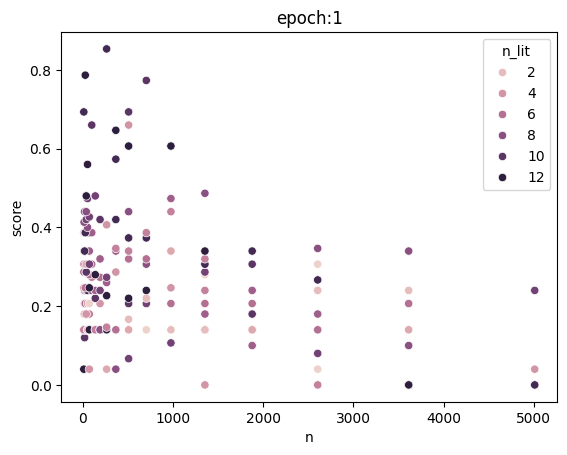

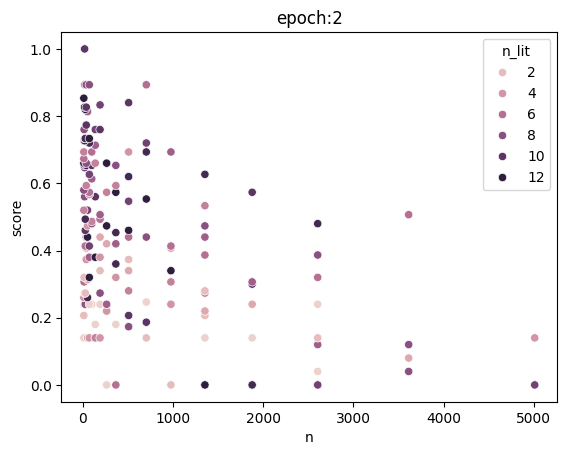

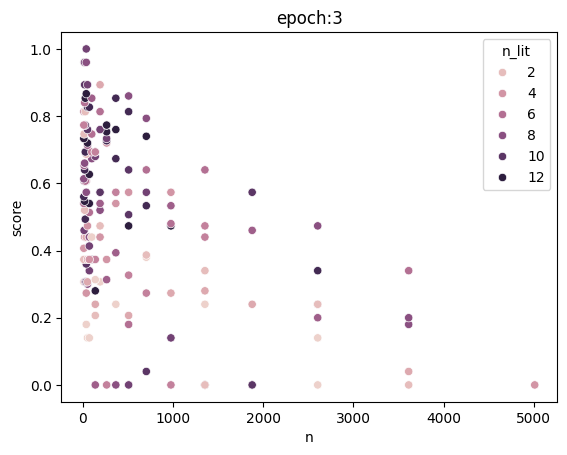

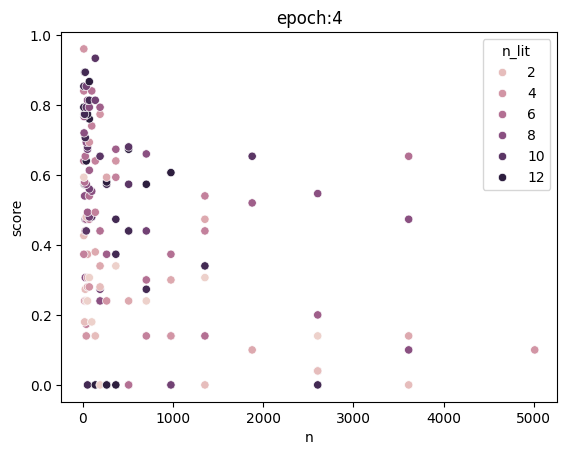

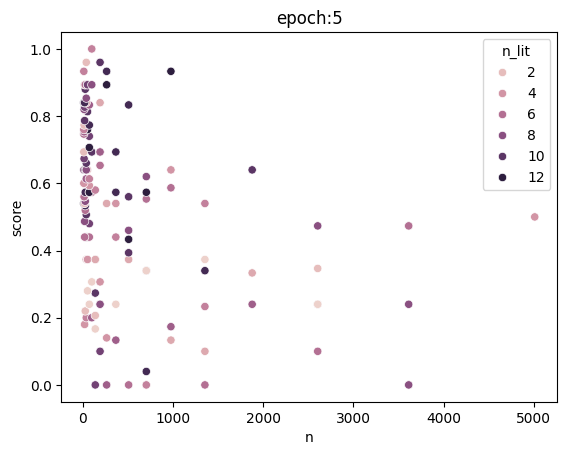

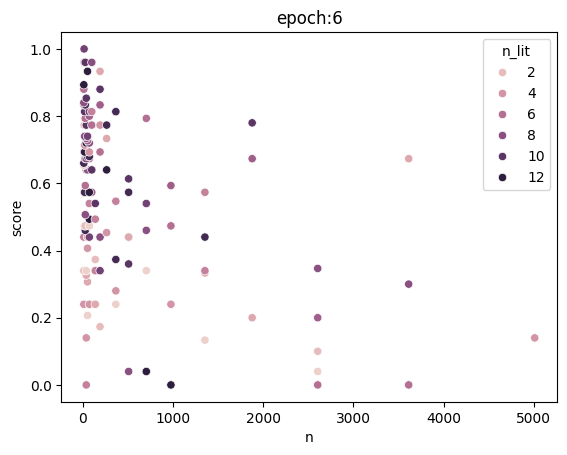

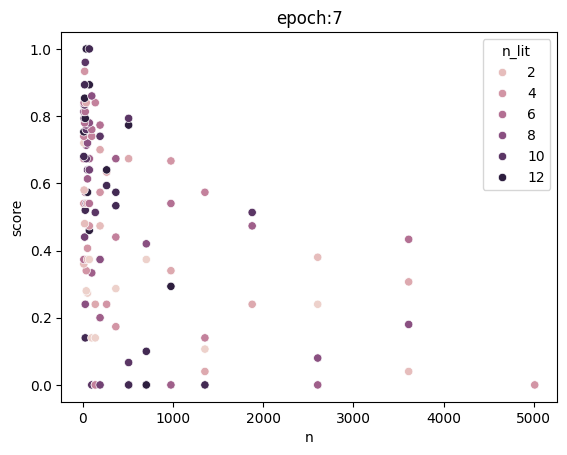

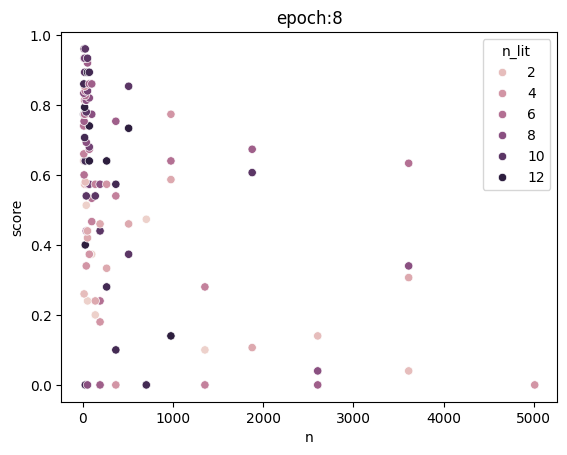

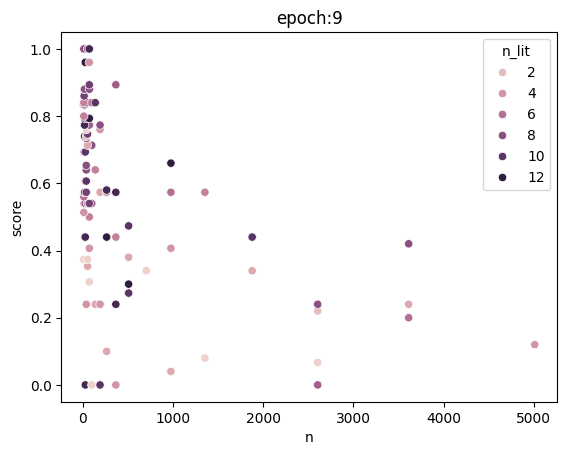

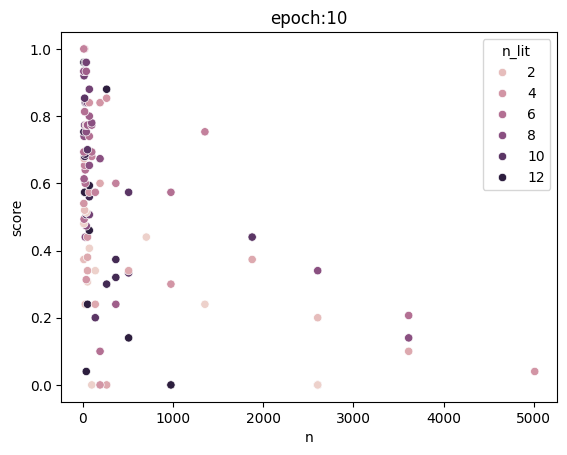

In [343]:
for e in mean_df["epoch"].unique():
    temp_df=mean_df[mean_df["epoch"]==e]
    plt.figure()
    sns.scatterplot(data=temp_df,x="n",y="score",hue="n_lit",
                )
    plt.title(f"epoch:{e}")

<Axes: >

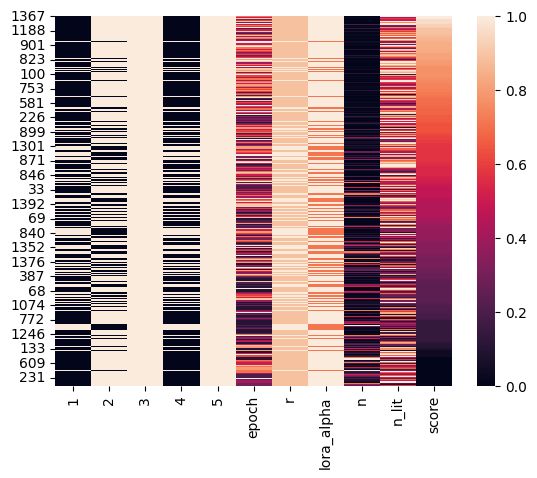

In [344]:
mean_df=mean_df.sort_values(["score"],ascending=False)
heat_df=mean_df.copy()
#heat_df=heat_df[heat_df["n"]>1000]
heat_df["epoch"]=heat_df["epoch"]/max(heat_df["epoch"])
heat_df["r"]=np.log10(heat_df["r"])
heat_df["r"]=heat_df["r"]/max(heat_df["r"])
heat_df["n"]=heat_df["n"]/max(heat_df["n"])
heat_df["n_lit"]=heat_df["n_lit"]/max(heat_df["n_lit"])
heat_df["lora_alpha"]=np.log10(heat_df["lora_alpha"])
heat_df["lora_alpha"]=heat_df["lora_alpha"]/max(heat_df["lora_alpha"])
sns.heatmap(heat_df.drop(["Number of layers"],axis=1).astype(float))

,1,2,3,4,5,epoch,r,lora_alpha,n,n_lit,score,Number of layers
1367,1,0,1,1,1,1.0,1.000000,0.714286,0.001996,0.416667,1.0,4
737,0,1,1,0,1,0.7,0.888889,1.000000,0.007384,1.000000,1.0,3
168,0,1,1,0,1,0.2,0.888889,1.000000,0.003792,0.833333,1.0,3
750,0,1,1,0,1,0.7,0.888889,1.000000,0.014169,0.916667,1.0,3
317,0,1,1,0,1,0.3,0.888889,1.000000,0.007384,0.750000,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
399,0,1,1,0,1,0.3,0.888889,1.000000,0.374576,0.083333,0.0,3
398,0,1,1,0,1,0.3,0.888889,1.000000,0.270006,0.916667,0.0,3
397,0,1,1,0,1,0.3,0.888889,1.000000,0.270006,0.666667,0.0,3
396,0,1,1,0,1,0.3,0.888889,1.000000,0.270006,0.583333,0.0,3


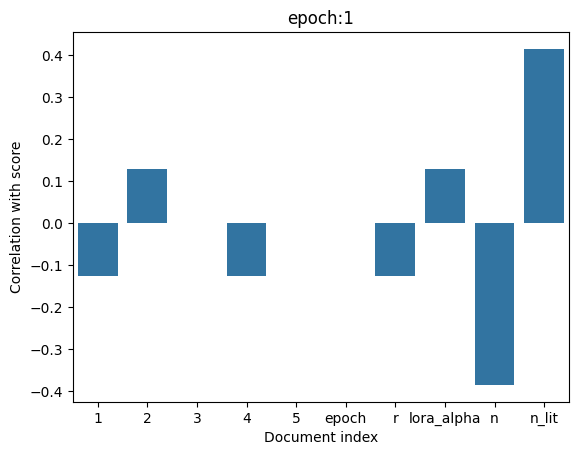

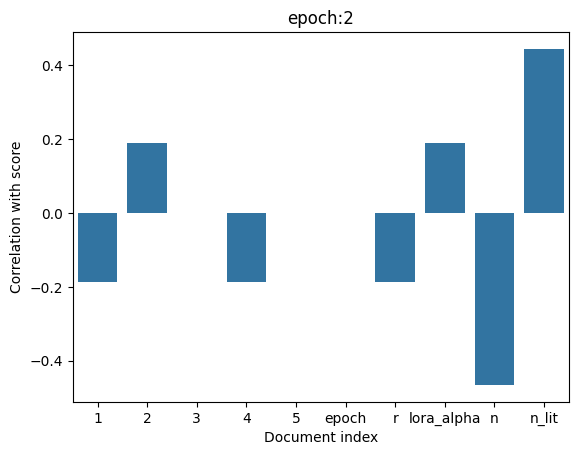

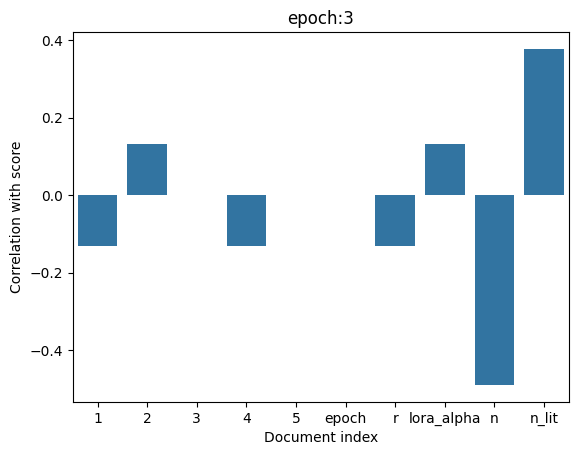

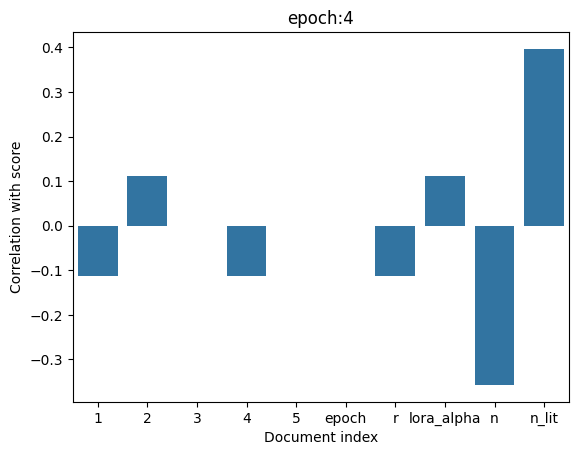

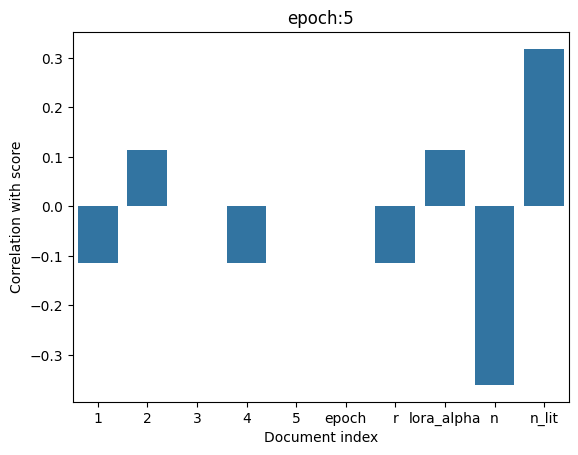

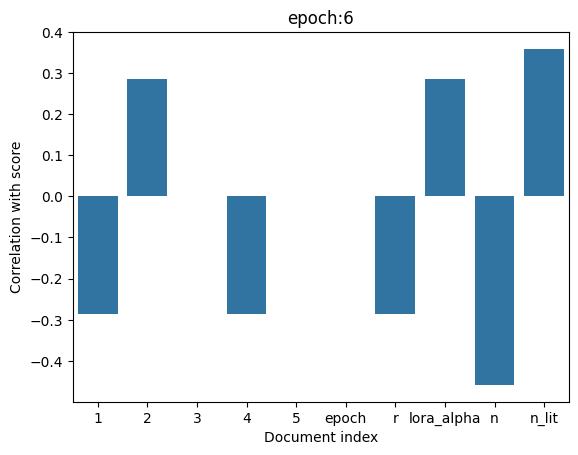

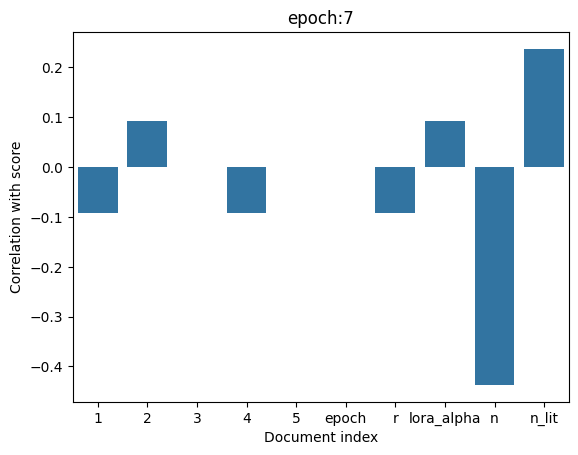

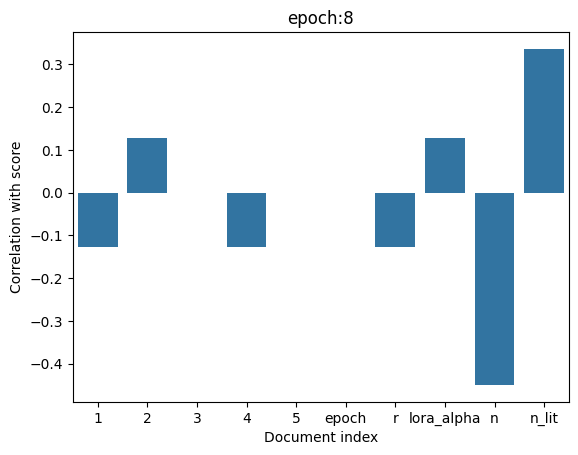

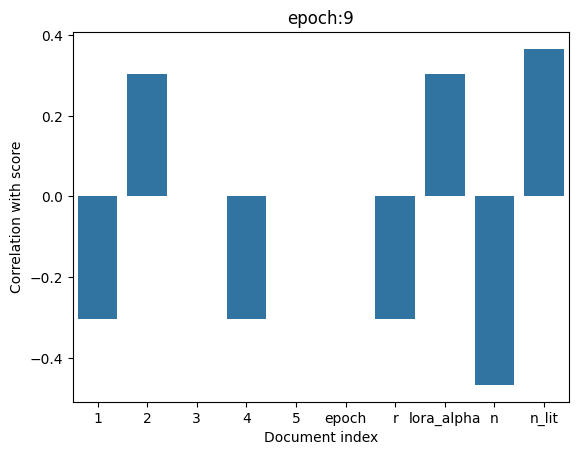

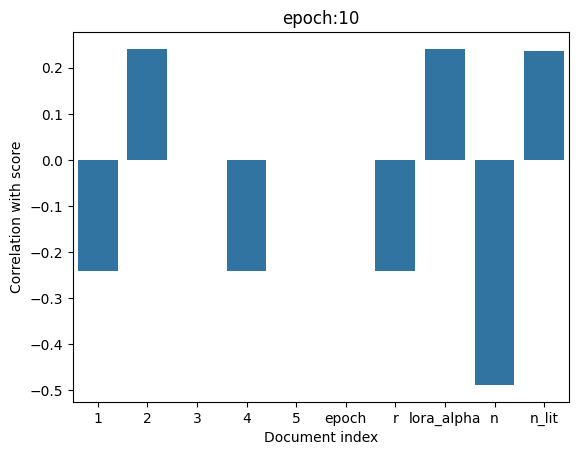

In [346]:
#heatmap


for e in sorted(mean_df["epoch"].unique()):
    temp_df=mean_df[mean_df["epoch"]==e]
    corr_df=temp_df.corr().drop(["score","Number of layers"])

    #corr_df.columns=full_lora_modules+["epoch","score","Number of layers"]
    plt.figure()
    sns.barplot(data=corr_df["score"])
    plt.ylabel("Correlation with score")
    plt.xlabel("Document index")
    plt.title(f"epoch:{e}")

In [347]:
full_lora_modules = [
    "embed_tokens",
    "lm_head",
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
]

In [348]:
2,9

(2, 9)

In [349]:
#k,o,down